In [146]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
%matplotlib inline

### loading preprocessed dataset

In [351]:
df = pd.read_csv('tmp/mse_raw.csv', parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [352]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


## feature engineering

In [353]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [354]:
df_final = df.copy()

In [355]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

### date extraction

In [356]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
df_final['sales_elapsed'] = df_final.date - df_final.start_date
df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [357]:
display_all(df_final.tail(2))

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
189837,VITA,2020-08-24,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,24,0,237,False,False,False,False,False,False,31,True,7986
189859,VITA,2020-08-25,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,25,1,238,False,False,False,False,False,False,31,True,7987


### rolling

In [358]:
df_final = df_final.set_index('date')

In [359]:
df_final.head(3)

,stock_id,open,high,low,average,close,volume,quantity,change %,volume total,...,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,...,9,False,False,False,False,False,False,31,False,0
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,10,False,False,False,False,False,False,31,False,1
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,11,False,False,False,False,False,False,31,False,2


In [360]:
#rolloing list for 30 days target shifted by 30 days
sum_7_qty_by_stock = []
sum_30_qty_by_stock = []
volumne_moving_avg_7 = []
volumne_moving_avg_30 = []
close_moving_avg_7 = []
close_moving_avg_30 = []
close_volatility_7 = []
close_volatility_30 = []
max_7_days = []
max_30_days = []
min_7_days = []
min_30_days = []
change_by_stock_daily_prev = []
profitability_daily_prev = []
ratio_prev = []

In [361]:
for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum_7 = df_final[df_final.stock_id == stock].quantity.shift(30).rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum_7)
    # sum quantity over last 30 days
    qty_sum_30 = df_final[df_final.stock_id == stock].quantity.shift(30).rolling(30).sum()
    sum_30_qty_by_stock.append(qty_sum_30)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.shift(30).rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on volumne over last 30 days
    volumne_ma_30 = df_final[df_final.stock_id == stock].volume.shift(30).rolling(30).mean()
    volumne_moving_avg_30.append(volumne_ma_30)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.shift(30).rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # moving average on close price over last 30 days
    close_ma_30 = df_final[df_final.stock_id == stock].close.shift(30).rolling(30).mean()
    close_moving_avg_30.append(close_ma_30)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(7).std() #shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # volatility in close price over last 30 days
    close_volatility_30_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(30).std() #shift()
    close_volatility_30.append(close_volatility_30_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # max close price in last 30 days
    max_30_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(30).max()
    max_30_days.append(max_30_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(7).min()
    min_7_days.append(min_7_by_stock)
    # min close price in last 30 days
    min_30_by_stock = df_final[df_final.stock_id == stock].close.shift(30).rolling(30).min()
    min_30_days.append(min_30_by_stock)
    # ratio overall will be average price devided by max closing price over all time
    #mean_close_price = df_final[df_final.stock_id == stock].close.shift(30).mean()
    #ratio_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(30) / mean_close_price
    #ratio_prev.append(ratio_by_stock_prev)
    
    # daily_change new feature
    #today = df_final[df_final.stock_id == stock].close.shift(30)
    #yesterday = today.shift(31)
    #change_by_stock =  today / yesterday - 1
    #change_by_stock_daily_prev.append(change_by_stock)
    
    # daily_profitability_prev new feature
    #profitability_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(30) - df_final[df_final.stock_id == stock].open.shift(30)
    #profitability_daily_prev.append(profitability_by_stock_prev)

In [362]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_2 = itertools.chain.from_iterable(sum_30_qty_by_stock)
flattened_list_2 = list(chain_object_2)

chain_object_3 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_4 = itertools.chain.from_iterable(volumne_moving_avg_30)
flattened_list_4 = list(chain_object_4)

chain_object_5 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_5 = list(chain_object_5)

chain_object_6 = itertools.chain.from_iterable(close_moving_avg_30)
flattened_list_6 = list(chain_object_6)

chain_object_7 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_7 = list(chain_object_7)

chain_object_8 = itertools.chain.from_iterable(close_volatility_30)
flattened_list_8 = list(chain_object_8)

chain_object_9 = itertools.chain.from_iterable(max_7_days)
flattened_list_9 = list(chain_object_9)

chain_object_10 = itertools.chain.from_iterable(max_30_days)
flattened_list_10 = list(chain_object_10)

chain_object_11 = itertools.chain.from_iterable(min_7_days)
flattened_list_11 = list(chain_object_11)

chain_object_12 = itertools.chain.from_iterable(min_30_days)
flattened_list_12 = list(chain_object_12)

ratio_object = itertools.chain.from_iterable(ratio_prev)
flattened_list_13 = list(ratio_object)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily_prev)
flattened_list_14 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily_prev)
flattened_list_15 = list(profitability_object)

In [363]:
rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1,
                               'sum_30_qty_by_stock':flattened_list_2,
                               'moving_avg_volume_7_days':flattened_list_3,
                               'moving_avg_volume_30_days':flattened_list_4,
                               'moving_avg_close_7_days':flattened_list_5,
                               'moving_avg_close_30_days':flattened_list_6,
                               'volatility_7_days':flattened_list_7,
                               'volatility_30_days':flattened_list_8,
                               'max_7_days':flattened_list_9,
                               'max_30_days':flattened_list_10,
                               'min_7_days':flattened_list_11,
                               'min_30_days':flattened_list_12
                               #'ratio_overall_prev':flattened_list_13,
                               #'change_daily_prev':flattened_list_14,
                               #'profitability_daily_prev':flattened_list_15
                              }
                             )

In [364]:
print(df_final.shape, rolling_7_days.shape)

(164754, 26) (164754, 12)


In [365]:
df_7_days = pd.concat([df_final.reset_index(), rolling_7_days], axis=1)

In [366]:
len(df_7_days.columns)

39

In [367]:
ratio_7_days = []
ratio_30_days = []

# Calculating ratios up to 7 and 30 days
for stock in df_7_days.stock_id.unique():
    ratio_7 = df_7_days[df_7_days.stock_id == stock].average.shift(30) / df_7_days[df_7_days.stock_id == stock].average.shift(30).mean()
    ratio_30 = df_7_days[df_7_days.stock_id == stock].average.shift(30) / df_7_days[df_7_days.stock_id == stock].average.shift(30).mean()
    ratio_7_days.append(ratio_7)
    ratio_30_days.append(ratio_30)


In [368]:
chain_object_16 = itertools.chain.from_iterable(ratio_7_days)
flattened_list_16 = list(chain_object_16)

chain_object_17 = itertools.chain.from_iterable(ratio_30_days)
flattened_list_17 = list(chain_object_17)

ratios_df = pd.DataFrame({'ratio_7_days':flattened_list_16,
                          'ratio_30_days':flattened_list_17
                         }
                        )

In [369]:
df_7_days = pd.concat([df_7_days, ratios_df], axis=1)

In [370]:
len(df_7_days.columns)

41

In [371]:
### Add column based on data analysis

# 1 day
df_7_days['prevopen_1'] = df_7_days.groupby(['stock_id'])['open'].shift(30)
#(open - prevopen) / prevopen
df_7_days['returnsOpenPrevRaw1'] = (df_7_days.open.shift(31) - df_7_days.prevopen_1) / df_7_days.prevopen_1

#10 days
df_7_days['prevopen_7'] = df_7_days.groupby(['stock_id'])['open'].shift(37)
df_7_days['returnsOpenPrevRaw_7'] = (df_7_days.open.shift(31) - df_7_days.prevopen_7) / df_7_days.prevopen_7

#Rate of change

# pct_chg = lambda x:x.pct_change()
# df_7_days['pct'] = df_7_days.groupby(['stock_id'])['close'].apply(pct_chg)

#Z-score
# zscore = lambda x:(x-x.mean())/x.std()
# df_7_days['z_score'] = df_7_days.groupby(['stock_id'])['close'].apply(zscore)

#percentile transformation
#rollrank = lambda x: x.rolling(200, min_periods=20).apply(lambda x:pd.Series(x).rank(pct=True)[0])
#df_7_days['percentile'] = df_7_days.groupby(['stock_id'])['volume'].apply(rollrank)

In [372]:
display_all(df_7_days[df_7_days.stock_id=='ALK'].tail(5).T)

,8625,8626,8627,8628,8629
date,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
stock_id,ALK,ALK,ALK,ALK,ALK
open,12223,12290,12290,12290,12290
high,12290,12290,12290,12290,12222
low,12289,12290,12290,12289,12200
average,12289.5,12290,12290,12289.7,12201.5
close,12290,12290,12290,12290,12200
volume,614476,0,0,73738,3.66044e+06
quantity,50,0,0,6,300
change %,-0.05,0,0,0,-0.72


### setting ALK dataset for training, validation and test

In [379]:
alk_df = df_7_days[df_7_days.stock_id == 'ALK']

In [380]:
to_drop = ['date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'quantity', 'change %', 'volume total']

In [381]:
alk_df = alk_df.dropna()

In [382]:
alk_df.drop(to_drop, axis=1, inplace=True)

In [383]:
len(alk_df.columns)

35

In [385]:
display_all(alk_df.head(5))

,close,start_date,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed,sum_7_qty_by_stock,sum_30_qty_by_stock,moving_avg_volume_7_days,moving_avg_volume_30_days,moving_avg_close_7_days,moving_avg_close_30_days,volatility_7_days,volatility_30_days,max_7_days,max_30_days,min_7_days,min_30_days,ratio_7_days,ratio_30_days,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7
59,2450.0,1997-01-09,1997,3,10,9,6,68,False,False,False,False,False,False,31,False,59,1175.0,3193.0,167857.142857,108205.000000,1000.000000,1022.333333,0.000000,26.087827,1000.0,1070.0,1000.0,1000.0,0.226401,0.226401,1000.0,0.0,1000.0,0.0
60,2450.0,1997-01-09,1997,3,11,10,0,69,False,False,False,False,False,False,31,False,60,1175.0,2932.0,167857.142857,98896.000000,1000.000000,1020.000000,0.000000,24.774848,1000.0,1070.0,1000.0,1000.0,0.226401,0.226401,1000.0,0.0,1000.0,0.0
61,970.0,1997-01-09,1997,3,11,11,1,70,False,False,False,False,False,False,31,False,61,1175.0,2932.0,167857.142857,98896.000000,1000.000000,1017.666667,0.000000,23.146212,1000.0,1070.0,1000.0,1000.0,0.226401,0.226401,1000.0,0.0,1000.0,0.0
62,970.0,1997-01-09,1997,3,11,12,2,71,False,False,False,False,False,False,31,False,62,1175.0,2932.0,167857.142857,98896.000000,1000.000000,1015.333333,0.000000,21.129051,1000.0,1070.0,1000.0,1000.0,0.226401,0.226401,1000.0,0.0,1000.0,0.0
63,970.0,1997-01-09,1997,3,11,13,3,72,False,False,False,False,False,False,31,False,63,871.0,3407.0,124064.285714,114644.333333,995.714286,1012.000000,11.338934,20.068847,1000.0,1070.0,970.0,970.0,0.225185,0.225185,1000.0,0.0,1000.0,0.0


### split dataset

In [386]:
scaler = StandardScaler()
normalizer = Normalizer()

In [387]:
X, y = alk_df.drop(['start_date','close'], axis=1), alk_df.close

In [388]:
def split_vals(dataset, n_test):
    n = dataset.shape[0] - n_test
    train_valid = dataset[:n].copy()
    return train_valid[:-n_test].copy(), train_valid[-n_test:n].copy(), dataset[-n_test:]

n_test = 30
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8511, 33), (30, 33), (30, 33), (8511,), (30,), (30,))

In [389]:
import math

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(model, X_train, y_train, X_valid, y_valid):
    res = [np.sqrt(mean_squared_error(model.predict(X_train), y_train)), 
           np.sqrt(mean_squared_error(model.predict(X_valid), y_valid)),
           model.score(X_train, y_train),
           model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
    print(res)

### Fine-tune RandomForestRegressor

In [399]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=10, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Wall time: 552 ms
[45.62889031672432, 241.7017280313348, 0.9997505692485031, -0.6709589540532115, 0.9776243563295219]


In [400]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
#print(f"Trees: {len(preds[:,0])},", f"Mean of 0th row for prediction from all trees: : {np.mean(preds[:,0])},", f"Actual y: {y_valid[0]}")

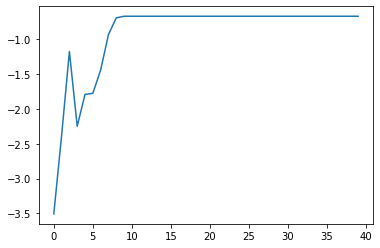

In [401]:
from sklearn import metrics
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

In [ ]:
import graphviz, IPython
from sklearn.tree import export_graphviz
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
draw_tree(model.estimators_[0], X_valid, precision=3)

In [ ]:
print(np.sqrt(mean_squared_error(model.predict(X_valid), y_valid)))

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(model, X_train)
fi[:10]

In [ ]:
fi.plot('cols', 'imp', figsize=(12,4), legend=False);

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

In [ ]:
to_keep = fi[fi.imp>0.005].cols;
len(to_keep)

In [ ]:
df_keep = alk_df[to_keep].copy()
X_train_keep, X_valid_keep, X_test_keep = split_vals(df_keep, n_test)

In [ ]:
model_keep = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_keep.fit(X_train_keep, y_train)
print_score(model_keep, X_train_keep, y_train, X_valid_keep, y_valid)

In [ ]:
from scipy.cluster import hierarchy as hc

corr = np.round(sp.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    x, _, _ = split_vals(df, n_test)
    m.fit(x, y_train)
    return m.oob_score_

In [ ]:
get_oob(df_keep)

In [ ]:
for c in ('moving_avg_close_7_days', 'max_7_days', 'prevopen_1', 'ratio_overall_prev'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

### extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_test] = 0

In [ ]:
X_ext, y_ext = df_ext.drop('is_valid', axis=1), df_ext.is_valid

In [ ]:
X_train_ext, X_valid_ext, X_test_ext = split_vals(X_ext, n_test)
y_train_ext, y_valid_ext, y_test_ext = split_vals(y_ext, n_test)

In [ ]:
model_ext = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_ext.fit(X_train_ext, y_train_ext)
model_ext.oob_score_

In [ ]:
fi = rf_feat_importance(model_ext, X_train_ext); fi[:10]

In [ ]:
feats=['sales_elapsed', 'max_30_days']
(X_train_ext[feats]/1000).describe()

In [ ]:
X_train_ext.columns

In [ ]:
X_train_ext.drop(feats, axis=1, inplace=True)
m_drop = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
m_drop.fit(X_train_ext, y_train_ext);
m_drop.oob_score_

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train_sub, X_valid_sub, X_test_sub = split_vals(df_subs, n_test)
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    m.fit(X_train_sub, y_train_ext)
    print(f)
    print_score(m, X_train_sub, y_train_ext, X_valid_sub, y_valid_ext)

### final model

In [ ]:
X, y = alk_df.drop(['close', 'sales_elapsed', 'max_30_days'], axis=1), alk_df.close

In [ ]:
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

In [ ]:
model_final = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_final.fit(X_train, y_train)
print_score(model_final, X_train, y_train, X_valid, y_valid)

In [ ]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, model_final.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [ ]:
ranfor_pred = model_final.predict(X_test)

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, ranfor_pred, color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### qty forecast

In [ ]:
alk_df_qty = df_7_days[df_7_days.stock_id == 'ALK']
alk_df_qty = alk_df_qty.dropna()
to_drop_qty = ['date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'close', 'change %', 'volume total']
alk_df_qty.drop(to_drop_qty, axis=1, inplace=True)

In [ ]:
X_qty, y_qty = alk_df_qty.drop('quantity', axis=1), alk_df_qty.quantity

In [ ]:
X_train_qty, X_valid_qty, X_test_qty = split_vals(X_qty, n_test)
y_train_qty, y_valid_qty, y_test_qty = split_vals(y_qty, n_test)
X_train_qty.shape, X_valid_qty.shape, X_test_qty.shape, y_train_qty.shape, y_valid_qty.shape, y_test_qty.shape

In [ ]:
%%time

parametars = {
    'n_estimators': [30, 50, 100, 150, 200, 300, 400, 500],
    'min_samples_leaf': [1, 3, 5, 10, 25]
}

model_qty = RandomForestRegressor(n_jobs=-1, max_features=0.5)
clf = GridSearchCV(model_qty, parametars)
clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best score = {clf.best_score_}')

In [ ]:
model_qty = RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_qty.fit(X_train_qty, y_train_qty)
print_score(model_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

In [ ]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, model_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [ ]:
ranfor_pred_qty = model_qty.predict(X_test_qty)

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(y_test_qty, ranfor_pred_qty, color='red')
plt.plot([y_train_qty.min(), y_train_qty.max()], [y_train_qty.min(), y_train_qty.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### XGBOOST

In [ ]:
xgb_reg = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.05, n_estimators=400, 
                           gamma=0.02, max_depth=15)

In [ ]:
xgb_reg.fit(X_train, y_train)
print_score(xgb_reg, X_train, y_train, X_valid, y_valid)

In [ ]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, xgb_reg.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [ ]:
xgb_price = xgb_reg.predict(X_test)

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, xgb_price, color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - XGB')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

In [ ]:
xgb_reg_qty = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.05, n_estimators=400, 
                           gamma=0.02, max_depth=15)

In [ ]:
xgb_reg_qty.fit(X_train_qty, y_train_qty)
print_score(xgb_reg_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

In [ ]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, xgb_reg_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [ ]:
xgb_qty = xgb_reg_qty.predict(X_test_qty)

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(y_test_qty, xgb_qty, color='red')
plt.plot([y_train_qty.min(), y_train_qty.max()], [y_train_qty.min(), y_train_qty.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - XGB')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()